## Install Libraries

In [29]:
!pip install jupyterlab-code-formatter black isort
!pip install xarray rioxarray matplotlib numpy networkx seaborn netcdf4 h5netcdf dask "dask[distributed]" scipy cartopy folium --upgrade
!pip install dash dash_cytoscape jupyter-dash

## Dataset Exploration

In [2]:
import os

import rioxarray
import xarray as xr
from dask.distributed import Client

c = Client(n_workers=os.cpu_count() - 2, threads_per_worker=1)

/opt/conda/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33053 instead
  warnings.warn(


In [3]:
# Import all files from the folder - 2010-2023(Mar)

max_temp_xr = xr.open_mfdataset(
    "./dataset/tmax/*.nc",
    concat_dim="time",
    combine="nested",
    data_vars="minimal",
    coords="minimal",
    compat="override",
    parallel=True,
)

# Convert longitude range from -180-180 to 0-360

max_temp_xr.rio.write_crs("epsg:4326", inplace=True)
max_temp_xr["lon"] = (max_temp_xr.lon + 180) % 360 - 180

# Clip for CONUS, instead of the entire world

min_lat = 20
max_lat = 54
min_lon = -130
max_lon = -40

max_temp_xr = max_temp_xr.where(
    ((max_temp_xr.lat >= min_lat) & (max_temp_xr.lat <= max_lat))
    & ((max_temp_xr.lon >= min_lon) & (max_temp_xr.lon <= max_lon)),
    drop=True,
)

In [3]:
max_temp_xr

<xarray.Dataset>
Dimensions:      (time: 4822, lat: 68, lon: 180)
Coordinates:
  * lat          (lat) float32 53.75 53.25 52.75 52.25 ... 21.25 20.75 20.25
  * lon          (lon) float32 -129.8 -129.2 -128.8 ... -41.25 -40.75 -40.25
  * time         (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2023-03-15
    spatial_ref  int64 0
Data variables:
    tmax         (time, lat, lon) float32 dask.array<chunksize=(365, 68, 180), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/wd52ws/global_temp/
    version:        V1.0
    title:          CPC GLOBAL TEMP V1.0
    dataset_title:  CPC GLOBAL TEMP
    history:        Updated 2019-09-10 19:54:58
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globaltemp...

In [4]:
print(
    "The min and max latitude values in the data is:",
    max_temp_xr["tmax"]["lat"].values.min(),
    max_temp_xr["tmax"]["lat"].values.max(),
)
print(
    "The min and max latitude values in the data is:",
    max_temp_xr["tmax"]["lon"].values.min(),
    max_temp_xr["tmax"]["lon"].values.max(),
)
print("The earliest date in the data is:", max_temp_xr["tmax"]["time"].values.min())
print("The latest date in the data is:", max_temp_xr["tmax"]["time"].values.max())

The min and max latitude values in the data is: 20.25 53.75
The min and max latitude values in the data is: -129.75 -40.25
The earliest date in the data is: 2010-01-01T00:00:00.000000000
The latest date in the data is: 2023-03-15T00:00:00.000000000


#### Explore the trend for a specific heat event in June 2022 from 17th to 22nd

In [6]:
start_date = "2022-06-17"
end_date = "2022-06-22"
interval_conus = max_temp_xr["tmax"].sel(time=slice(start_date, end_date))
interval_conus

<xarray.DataArray 'tmax' (time: 6, lat: 68, lon: 180)>
dask.array<getitem, shape=(6, 68, 180), dtype=float32, chunksize=(6, 68, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 53.75 53.25 52.75 52.25 ... 21.25 20.75 20.25
  * lon          (lon) float32 -129.8 -129.2 -128.8 ... -41.25 -40.75 -40.25
  * time         (time) datetime64[ns] 2022-06-17 2022-06-18 ... 2022-06-22
    spatial_ref  int64 0
Attributes: (12/13)
    units:         degC
    var_desc:      Maximum Temperature
    level_desc:    Surface
    statistic:     Maximum
    parent_stat:   Other
    long_name:     Daily Maximum Temperature
    ...            ...
    valid_range:   [-90.  50.]
    avg_period:    0000-00-01 00:00:00
    dataset:       CPC Global Temperature
    comments:      GTS data and is gridded using the Shepard Algorithm
    max_period:    6z to 6z
    actual_range:  [-58.832264  51.679657]

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

2023-05-01 17:01:25,329 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 729.75 MiB -- Worker memory limit: 0.96 GiB
2023-05-01 17:01:25,480 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 796.38 MiB -- Worker memory limit: 0.96 GiB
2023-05-01 17:01:25,733 - distributed.worker.memory - WARNING - Worker is at 51% memory usage. Resuming worker. Process memory: 512.55 MiB -- Worker memory limit: 0.96 GiB


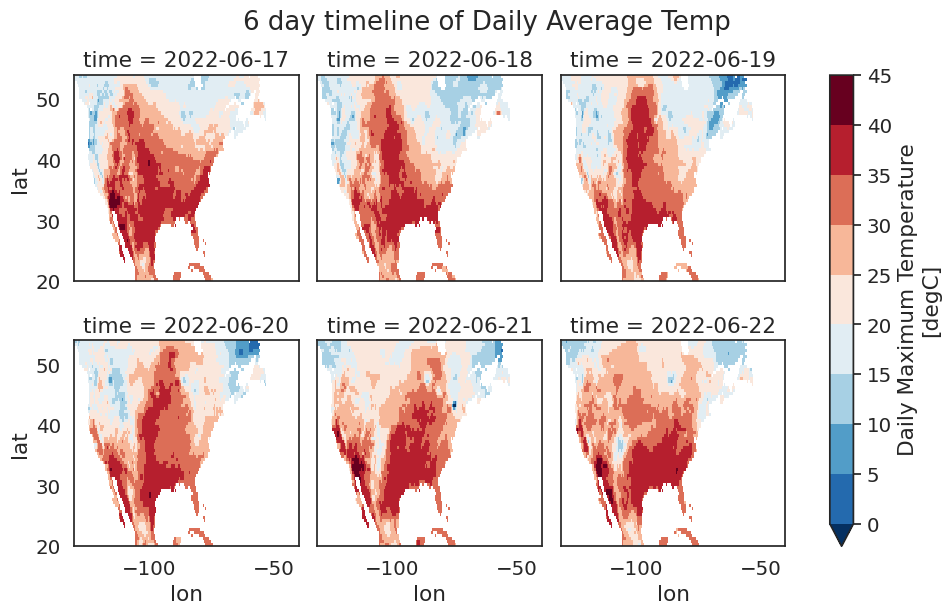

In [16]:
levels = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
interval_conus.plot(
    x="lon", y="lat", col="time", levels=levels, col_wrap=3, cm="viridis"
)
plt.suptitle("6 day timeline of Daily Average Temp", y=1.03)
plt.show()

We can see that a heatwave originated in the west and moved across the country to the east, over the course of 5 days.

## Network Creation

To create a network, we need to calculate the threshold for edge creation.

In [8]:
import numpy as np

interval = max_temp_xr.sel(time=slice(start_date, end_date))
lats = interval.variables["lat"][:].values
lons = interval.variables["lon"][:].values
times = interval.variables["time"][:].values
temps = interval.variables["tmax"].values
diffs_lat = np.abs(np.diff(temps, axis=1))
diffs_lat = np.pad(diffs_lat, ((0, 0), (0, 1), (0, 0)), mode="constant")
diffs_lon = np.abs(np.diff(temps, axis=2))
diffs_lon = np.pad(diffs_lon, ((0, 0), (0, 0), (0, 1)), mode="constant")
diffs_time = np.abs(np.diff(temps, axis=0))
diffs_time = np.pad(diffs_time, ((0, 1), (0, 0), (0, 0)), mode="constant")

diffs = np.maximum(diffs_lat, np.maximum(diffs_lon, diffs_time))

frac = 0.05  # 95th percentile
threshold = np.percentile(diffs[~np.isnan(diffs)], frac * 100)
threshold

2023-05-01 18:42:20,668 - distributed.worker.memory - WARNING - Worker is at 96% memory usage. Pausing worker.  Process memory: 0.93 GiB -- Worker memory limit: 0.96 GiB
2023-05-01 18:42:20,727 - distributed.worker.memory - WARNING - Worker is at 60% memory usage. Resuming worker. Process memory: 595.30 MiB -- Worker memory limit: 0.96 GiB


0.47679443359375

In [219]:
# import numpy as np
# import networkx as nx
# import matplotlib.pyplot as plt
# import xarray as xr
# import community as community_louvain

# def similarity_function(a, b):
#     return np.corrcoef(a, b)[0, 1]

# def create_spatio_temporal_network(tmax, threshold):
#     n_lat, n_lon = tmax.shape
#     nodes = [(lat, lon) for lat in range(n_lat) for lon in range(n_lon)]
#     G = nx.Graph()

#     G.add_nodes_from(nodes)

#     for i in range(n_lat):
#         for j in range(n_lon):
#             for k in range(i, n_lat):
#                 for l in range(j, n_lon):
#                     if i == k and j == l:
#                         continue

#                     time_series_a = tmax[i, j]
#                     time_series_b = tmax[k, l]
#                     similarity = similarity_function(time_series_a, time_series_b)

#                     if abs(similarity) >= threshold:
#                         G.add_edge((i, j), (k, l), weight=similarity)

#     return G

# def detect_areas(G):
#     partition = community_louvain.best_partition(G)
#     return partition

# threshold = 0.6

# G = create_spatio_temporal_network(tmax, threshold)

# partition = detect_areas(G)

In [1]:
# import pandas as pd
# import numpy as np
# import networkx as nx

# df = pd.DataFrame({
#     'time': np.repeat(np.arange(temp_data.shape[0]), temp_data.shape[1] * temp_data.shape[2]),
#     'lat': np.tile(np.repeat(np.arange(temp_data.shape[1]), temp_data.shape[2]), temp_data.shape[0]),
#     'lon': np.tile(np.tile(np.arange(temp_data.shape[2]), temp_data.shape[1]), temp_data.shape[0]),
#     'temperature': temp_data.ravel()
# })

# node_dict = {(t, lat, lon): i for i, (t, lat, lon) in enumerate(zip(df['time'], df['lat'], df['lon']))}
# time, lat, lon = temp_data.shape
# corr_data = np.zeros((lat*lon, lat*lon))
# for t in range(time):
#     temp_t = temp_data[t,:,:].reshape((lat*lon,1))
#     corr_data += np.dot(temp_t, temp_t.T)
# corr_data /= time
# corr_data -= np.outer(np.mean(temp_data, axis=0), np.mean(temp_data, axis=0)) / time
# corr_data /= np.outer(np.std(temp_data, axis=0), np.std(temp_data, axis=0))

# def create_spatio_temporal_network(corr_data, threshold):
#     n_lat, n_lon = int(np.sqrt(corr_data.shape[0])), int(np.sqrt(corr_data.shape[0]))
#     nodes = [(lat, lon) for lat in range(n_lat) for lon in range(n_lon)]
#     G = nx.DiGraph()

#     G.add_nodes_from(nodes)

#     for i in range(n_lat):
#         for j in range(n_lon):
#             for k in range(i, n_lat):
#                 for l in range(j, n_lon):
#                     if i == k and j == l:
#                         continue

#                     similarity = corr_data[i * n_lon + j, k * n_lon + l]

#                     if abs(similarity) >= threshold:
#                         G.add_edge((i, j), (k, l), weight=similarity)

#     return G

# threshold = 0.6

# G = create_spatio_temporal_network(corr_data, threshold)

# pos = {node: node[::-1] for node in G.nodes()}  # Reverse lat, lon to get (x, y) coordinates for visualization
# nx.draw(G, pos, node_size=30, with_labels=False)
# plt.show()

# G = nx.DiGraph()
# G.add_weighted_edges_from(edges)

# nx.set_node_attributes(G, df.set_index(['time', 'lat', 'lon'])['temperature'].to_dict(), 'temperature')

In [11]:
# import networkx as nx
# import numpy as np

# G = nx.Graph()
# times = ["2022-06-17", "2022-06-18", "2022-06-19", "2022-06-20", "2022-06-21", "2022-06-22"]
# for t in range(len(times)):
#     for i in range(len(lats)):
#         for j in range(len(lons)):
#             temp = temps[t, i, j]
#             if(np.isnan(temp)):
#                 continue
#             # Add the current node to the graph
#             G.add_node((times[t], lats[i], lons[j]), temp=temp)

#             # Check if there is a node to the right and create an edge if the temperature difference is below a threshold
#             if j < len(lons) - 1:
#                 right_temp = temps[t, i, j + 1]
#                 if abs(temp - right_temp) <= threshold:
#                     G.add_edge(
#                         (times[t], lats[i], lons[j]), (times[t], lats[i], lons[j + 1])
#                     )

#             # Check if there is a node below and create an edge if the temperature difference is below a threshold
#             if i < len(lats) - 1:
#                 bottom_temp = temps[t, i + 1, j]
#                 if abs(temp - bottom_temp) <= threshold:
#                     G.add_edge(
#                         (times[t], lats[i], lons[j]), (times[t], lats[i + 1], lons[j])
#                     )

#             # Check if there is a node to the right and below and create an edge if the temperature difference is below a threshold
#             if i < len(lats) - 1 and j < len(lons) - 1:
#                 diagonal_temp = temps[t, i + 1, j + 1]
#                 if abs(temp - diagonal_temp) <= threshold:
#                     G.add_edge(
#                         (times[t], lats[i], lons[j]),
#                         (times[t], lats[i + 1], lons[j + 1]),
#                     )

#             # Check if there is a node to the left and below and create an edge if the temperature difference is below a threshold
#             if i < len(lats) - 1 and j > 0:
#                 diagonal_temp = temps[t, i + 1, j - 1]
#                 if abs(temp - diagonal_temp) <= threshold:
#                     G.add_edge(
#                         (times[t], lats[i], lons[j]),
#                         (times[t], lats[i + 1], lons[j - 1]),
#                     )

In [19]:
# # Create a new directed graph
# G = nx.DiGraph()
# times = ["2022-06-17", "2022-06-18", "2022-06-19", "2022-06-20", "2022-06-21", "2022-06-22"]
# for t in range(len(times)):
#     for i in range(len(lats)):
#         for j in range(len(lons)):
#             temp = temps[t, i, j]
#             G.add_node((times[t], lats[i], lons[j]), temp=temps[t, i, j])


# for t in range(len(times)):
#     for i in range(len(lats)):
#         for j in range(len(lons)):
#             # Get the temperature time series at node (i, j)
#             time_series_ij = temps[:, i, j]

#             # Find the neighbors of node (i, j)
#             neighbors = []
#             if i > 0:
#                 neighbors.append((i - 1, j))  # North neighbor
#             if i < len(lats) - 1:
#                 neighbors.append((i + 1, j))  # South neighbor
#             if j > 0:
#                 neighbors.append((i, j - 1))  # West neighbor
#             if j < len(lons) - 1:
#                 neighbors.append((i, j + 1))  # East neighbor

#             for neighbor in neighbors:
#                 ni, nj = neighbor

#                 # Get the temperature time series at the neighbor node (ni, nj)
#                 time_series_neighbor = temps[:, ni, nj]

#                 # Calculate the correlation between the time series
#                 correlation = similarity_function(time_series_ij, time_series_neighbor)

#                 # Add an edge if the correlation is above the threshold
#                 if abs(correlation) >= threshold:
#                     G.add_edge((times[t], lats[i], lons[j]), (times[t], lats[ni], lons[nj]), weight=correlation)

#### Add edges between nodes only if their temperature difference is within the specific threshold.



In [34]:
import networkx as nx

G = nx.DiGraph()
times = [
    "2022-06-17",
    "2022-06-18",
    "2022-06-19",
    "2022-06-20",
    "2022-06-21",
    "2022-06-22",
]
for t in range(len(times)):
    for i in range(len(lats)):
        for j in range(len(lons)):
            temp = temps[t, i, j]
            G.add_node((times[t], lats[i], lons[j]), temp=temps[t, i, j])


for t in range(len(times)):
    for i in range(len(lats)):
        for j in range(len(lons)):
            temp_ij = temps[t, i, j]
            if np.isnan(temp_ij):
                continue
            neighbors = [(i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1)]
            for neighbor in neighbors:
                ni, nj = neighbor
                if 0 <= ni < len(lats) and 0 <= nj < len(lons):
                    temp_neighbor = temps[t, ni, nj]
                    if np.isnan(temp_neighbor):
                        continue
                    temp_diff = abs(temp_neighbor - temp_ij)
                    if temp_diff <= threshold:
                        G.add_edge(
                            (times[t], lats[i], lons[j]),
                            (times[t], lats[ni], lons[nj]),
                            weight=temp_diff,
                        )

The area selection algorithm is used to identify and group regions of the spatio-temporal network that are interconnected and share similar characteristics. These areas can represent regions with similar temperature fluctuations or patterns that are closely correlated with each other. 

In [37]:
# Area selection algorithm - BFS for each timestamp
def area_selection(G, min_nodes=10):
    areas = []
    visited = set()
    times = sorted(set([node[0] for node in G.nodes]))
    for t in times:
        t_nodes = [node for node in G.nodes if node[0] == t]
        for node in t_nodes:
            if node not in visited:
                area_nodes = set()
                queue = [node]
                while queue:
                    current_node = queue.pop(0)
                    if current_node not in visited:
                        visited.add(current_node)
                        area_nodes.add(current_node)
                        queue.extend(list(G.neighbors(current_node)))
                if len(area_nodes) >= min_nodes:
                    areas.append(area_nodes)
    return areas

areas = area_selection(G)

In [65]:
import folium
from IPython.display import HTML

colors = ["red", "green", "blue", "orange", "purple", "gray"]
maps = []

for t in times:
    # Plot the areas on a map
    m = folium.Map(location=[np.mean(lats), np.mean(lons)], zoom_start=4)
    areas_t = [area for area in areas if list(area)[0][0] == t]
    for i, area in enumerate(areas_t):
        color = colors[i % len(colors)]
        lat_lons = [node[1:] for node in area]
        sw = np.min(lat_lons, axis=0)
        ne = np.max(lat_lons, axis=0)
        box = folium.Rectangle(
            bounds=[list(sw), list(ne)], color=color, fill=True, fill_opacity=0.2
        )
        m.add_child(box)

    # Add the map to the list of maps
    maps.append(m)

# Combine all the maps into one HTML page
html = "<br>".join([m._repr_html_() for m in maps])
display(HTML(html))

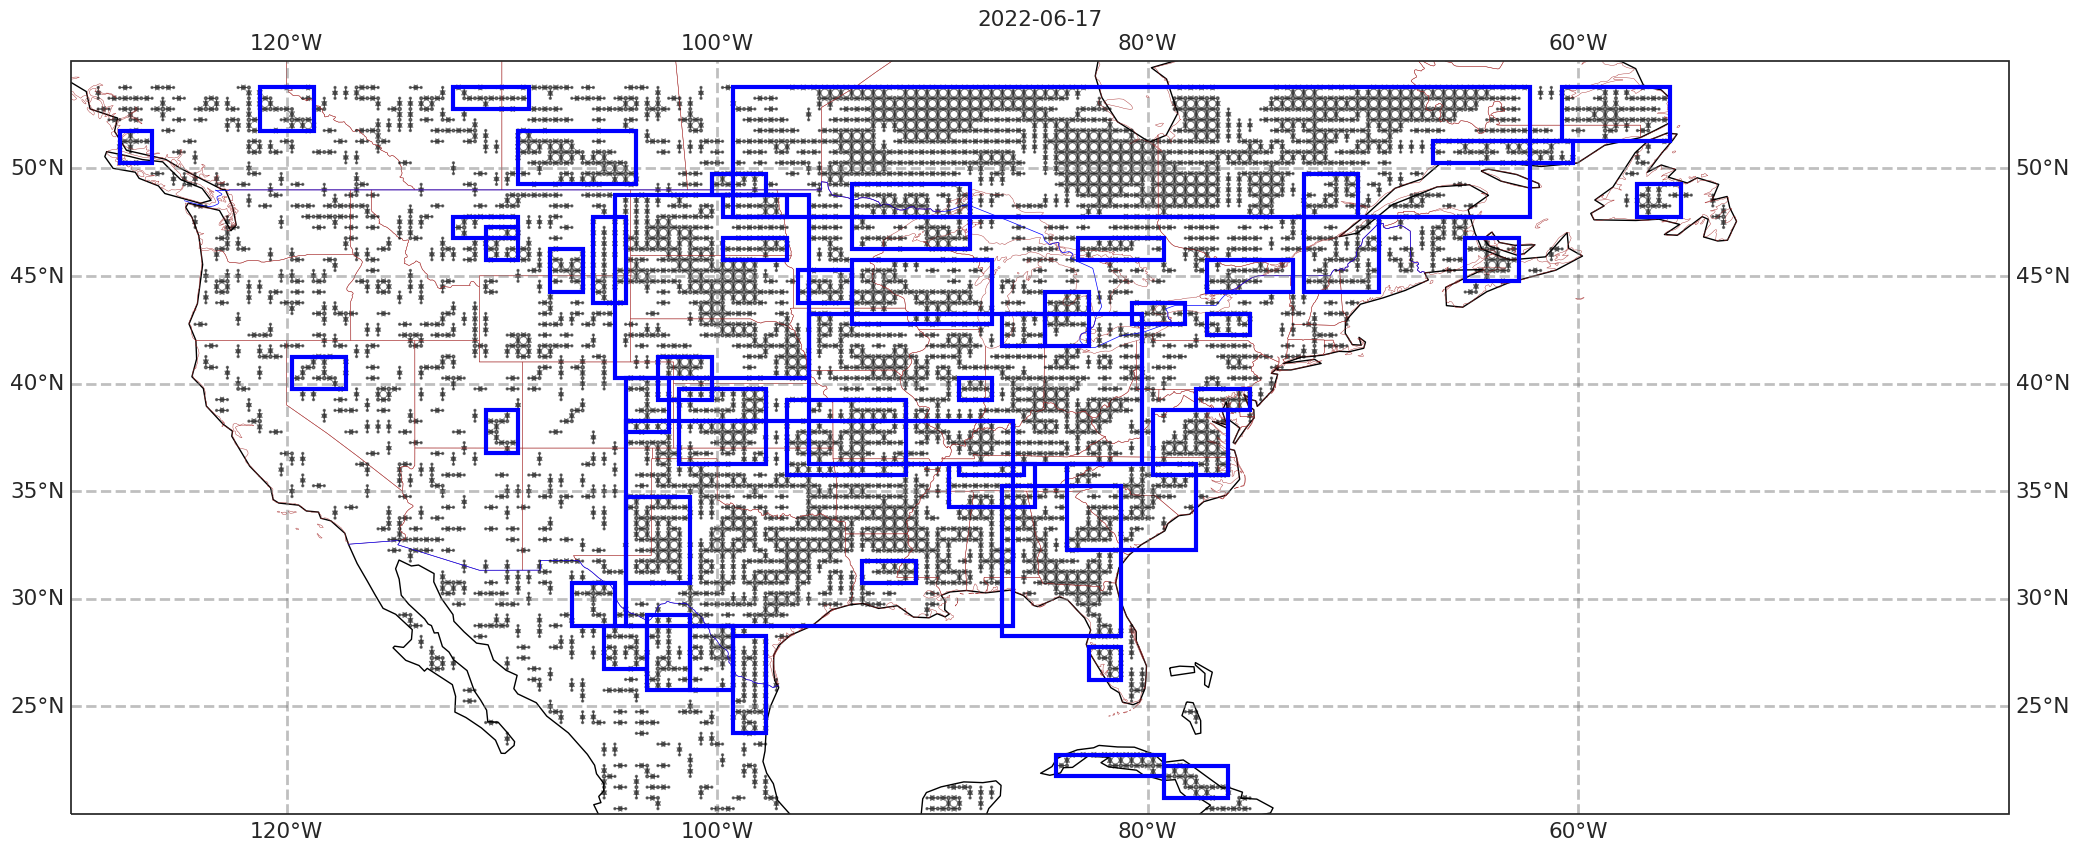

In [104]:
import matplotlib.colors as colors

day_nodes = [node for node in G.nodes if node[0] == '2022-06-17']
day_graph = G.subgraph(day_nodes)
areas = area_selection(day_graph)

deg = nx.degree(day_graph)
sizes = [deg[code] for code in day_graph.nodes]
temps_list = []
temps_locs = nx.get_node_attributes(day_graph, "temp")
for node in day_graph.nodes:
    temps_list.append(temps_locs[node])

low, *_, high = sorted(temps_list)
norm = colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

positions = {}
for node in day_graph.nodes():
    positions[node] = (node[2], node[1])

from matplotlib.patches import Rectangle

projPC = ccrs.PlateCarree()
lonW = -130
lonE = -40
latS = 20
latN = 55
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = "110m"

fig = plt.figure(figsize=(25, 20))
ax = plt.subplot(1, 1, 1, projection=projPC)
ax.set_title("2022-06-17")
gl = ax.gridlines(
    draw_labels=True, linewidth=2, color="gray", alpha=0.5, linestyle="--"
)
ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
ax.coastlines(resolution=res, color="black")
ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor="brown")
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor="blue")

nx.draw_networkx(
    day_graph,
    with_labels=False,
    ax=ax,
    alpha=0.5,
    width=0.4,
    node_size=sizes,
    pos=positions,
    arrows=True,
    node_color=[mapper.to_rgba(i) for i in temps_locs.values()],
)

# Plot areas as boxes
ax = plt.gca()
for idx, area in enumerate(areas):
    area_lats = [node[1] for node in area]
    area_lons = [node[2] for node in area]
    min_lat, max_lat = min(area_lats), max(area_lats)
    min_lon, max_lon = min(area_lons), max(area_lons)

    rect = Rectangle(
        (min_lon, min_lat),
        max_lon - min_lon,
        max_lat - min_lat,
        linewidth=3,
        edgecolor="blue",
        facecolor="none",
        zorder=3,
    )
    ax.add_patch(rect)

plt.show()

### Check interactions between these areas

We first find all the neighbors of the nodes in area1 within the specified `max_path_length` using `single_source_shortest_path_length` function. Then, we check if there are any common nodes between area1_neighbors and area2

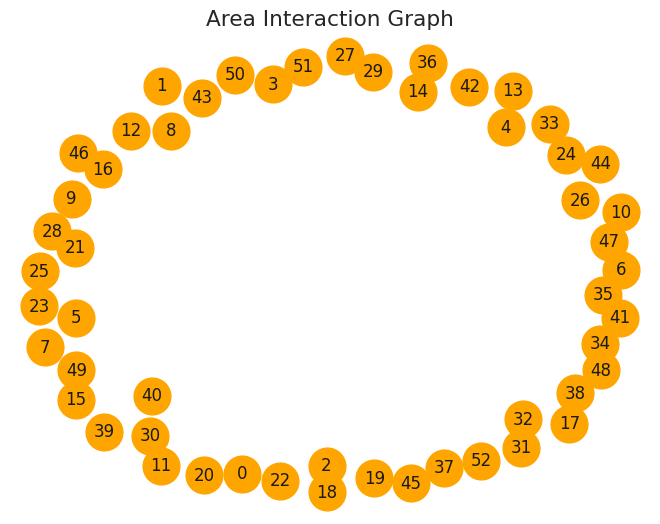

In [124]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.patches import Rectangle


def create_area_interaction_graph(G, areas, max_path_length=100):
    area_interaction_graph = nx.Graph()

    for i, area1 in enumerate(areas):
        area_interaction_graph.add_node(i)
        for j, area2 in enumerate(areas[i + 1 :], i + 1):
            if not area_interaction_graph.has_edge(i, j):
                area1_neighbors = set()
                for node1 in area1:
                    area1_neighbors.update(
                        nx.single_source_shortest_path_length(
                            G, node1, cutoff=max_path_length
                        )
                    )

                if any(node2 in area1_neighbors for node2 in area2):
                    area_interaction_graph.add_edge(i, j)
    return area_interaction_graph


area_interaction_graph = create_area_interaction_graph(G, areas, 2)

nx.draw(area_interaction_graph, with_labels=True, node_size=700, node_color="orange")
plt.title("Area Interaction Graph")
plt.show()

We see get that there are no common nodes between various areas.

#### Alternative


Check for interactions between areas based on the geographic coordinates of their nodes. For this, we will first calculate the bounding boxes for each area and then check for overlaps or adjacency between these bounding boxes to identify interactions.

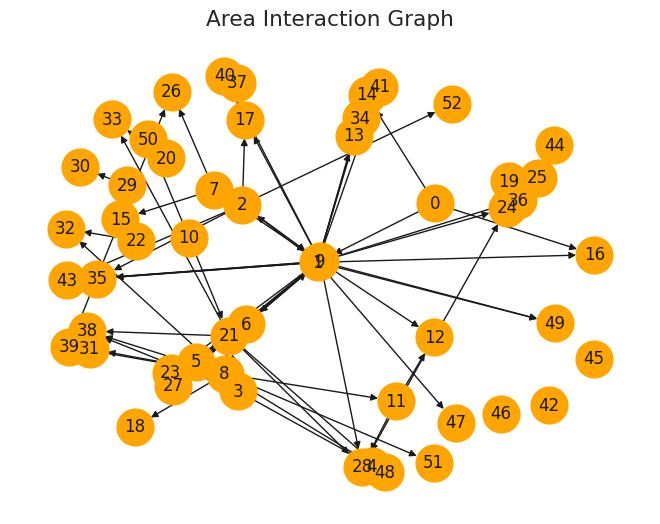

In [256]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


def area_bounding_box(area):
    lats = [lat for _, lat, _ in area]
    lons = [lon for _, _, lon in area]
    return (min(lats), max(lats), min(lons), max(lons))


def bounding_boxes_overlap(box1, box2, buffer=1):
    min_lat1, max_lat1, min_lon1, max_lon1 = box1
    min_lat2, max_lat2, min_lon2, max_lon2 = box2

    return (
        (min_lat1 - buffer <= max_lat2)
        and (min_lat2 - buffer <= max_lat1)
        and (min_lon1 - buffer <= max_lon2)
        and (min_lon2 - buffer <= max_lon1)
    )


def create_area_interaction_graph(G, areas, buffer=1):
    area_interaction_graph = nx.DiGraph()

    bounding_boxes = [area_bounding_box(area) for area in areas]

    for i, box1 in enumerate(bounding_boxes):
        area_interaction_graph.add_node(i)
        for j, box2 in enumerate(bounding_boxes[i + 1 :], i + 1):
            if bounding_boxes_overlap(box1, box2, buffer=buffer):
                area_interaction_graph.add_edge(i, j)

    return area_interaction_graph


area_interaction_graph = create_area_interaction_graph(G, areas, buffer=1)

nx.draw(area_interaction_graph, with_labels=True, node_size=700, node_color="orange")
plt.title("Area Interaction Graph")
plt.show()

In [257]:
for i, node in enumerate(area_interaction_graph.nodes):
    area = areas[node]
    latitudes = [node[1] for node in area]
    longitudes = [node[2] for node in area]
    latitude = np.mean(latitudes)
    longitude = np.mean(longitudes)
    area_interaction_graph.nodes[node]["latitude"] = latitude
    area_interaction_graph.nodes[node]["longitude"] = longitude

In [258]:
print(area_interaction_graph)

DiGraph with 53 nodes and 83 edges


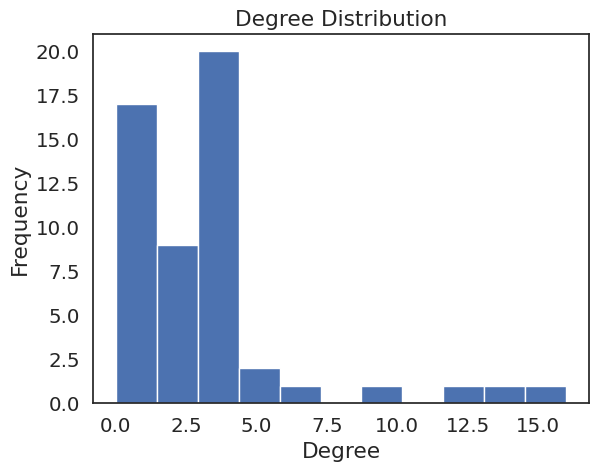

In [259]:
degree_sequence = sorted([d for n, d in area_interaction_graph.degree()], reverse=True)
plt.hist(degree_sequence, bins="auto")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [261]:
connected_components = list(nx.connected_components(nx.Graph(area_interaction_graph)))
print("Number of connected components:", len(connected_components))

Number of connected components: 8


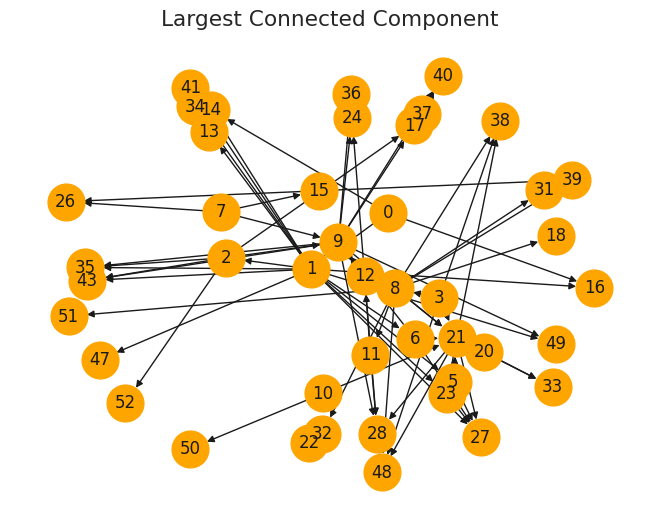

In [262]:
largest_cc = max(connected_components, key=len)
largest_cc_graph = area_interaction_graph.subgraph(largest_cc)
nx.draw(largest_cc_graph, with_labels=True, node_size=700, node_color="orange")
plt.title("Largest Connected Component")
plt.show()

In [263]:
centralities = {
    'degree': nx.degree_centrality(largest_cc_graph),
    'closeness': nx.closeness_centrality(largest_cc_graph),
    'betweenness': nx.betweenness_centrality(largest_cc_graph)
}

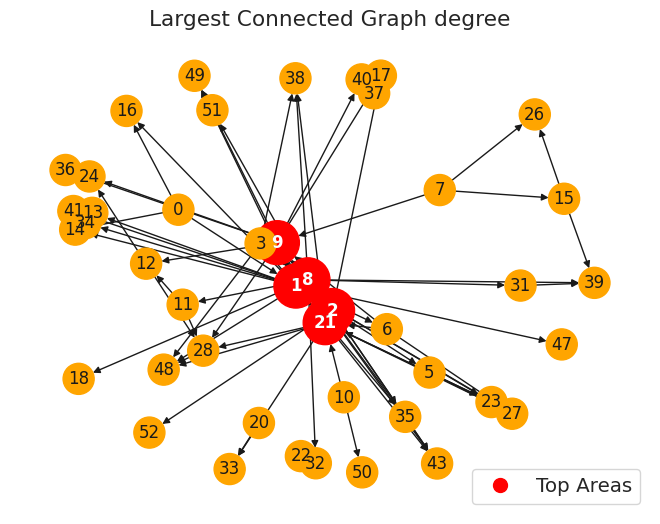

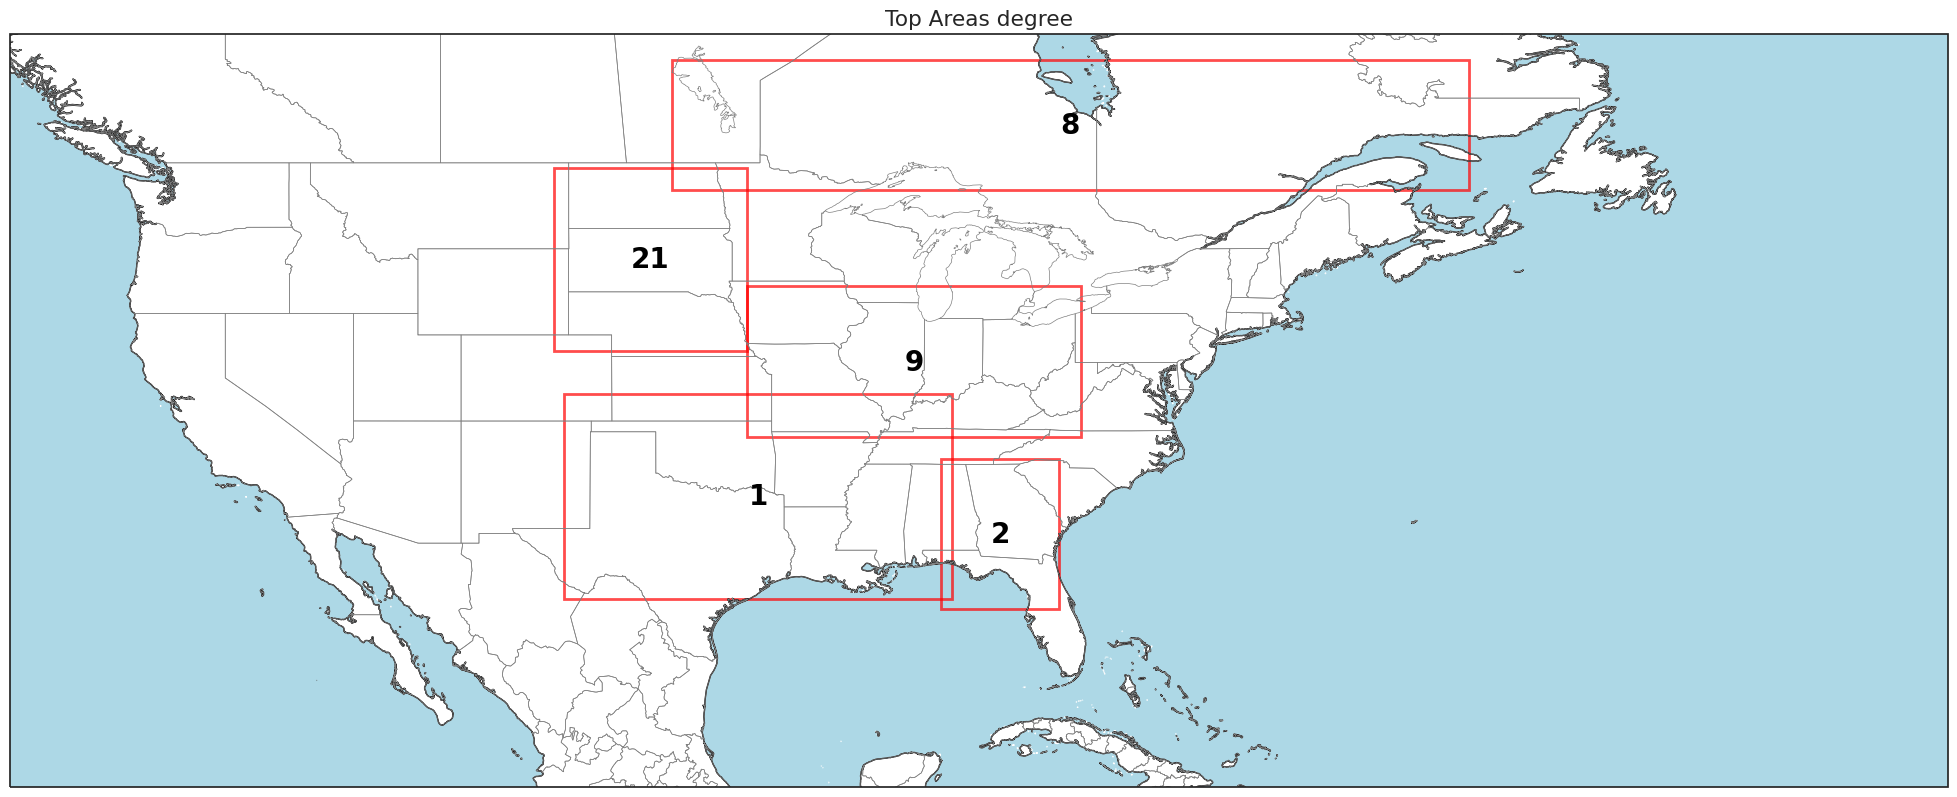

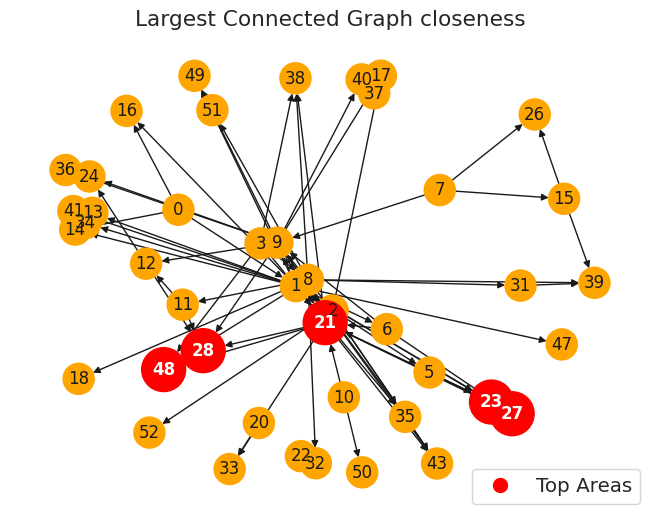

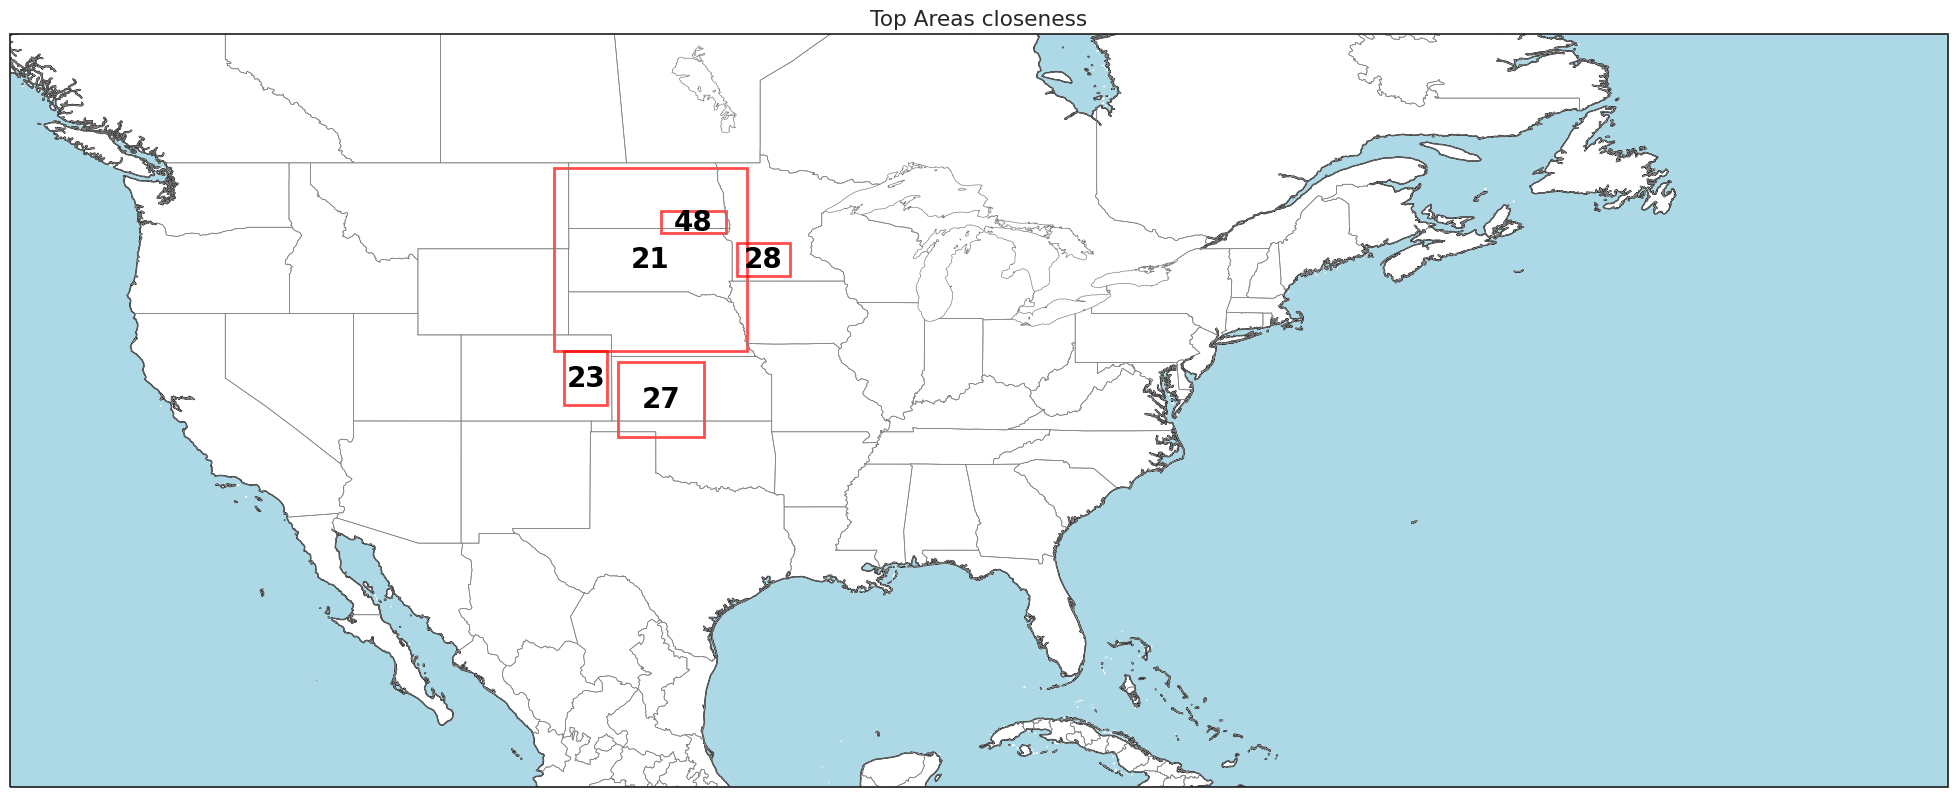

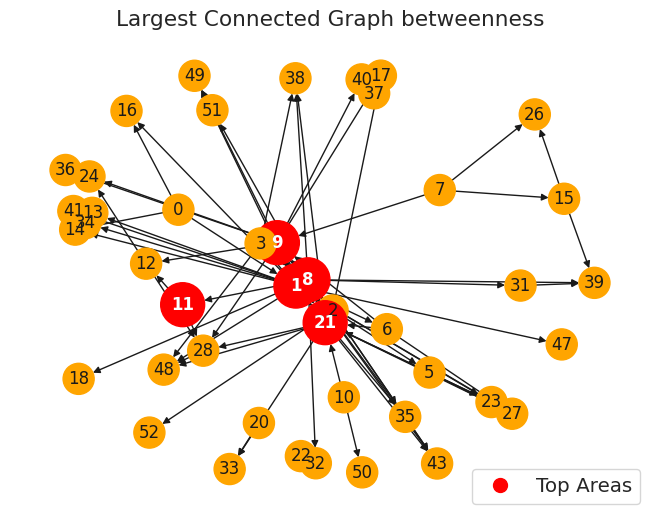

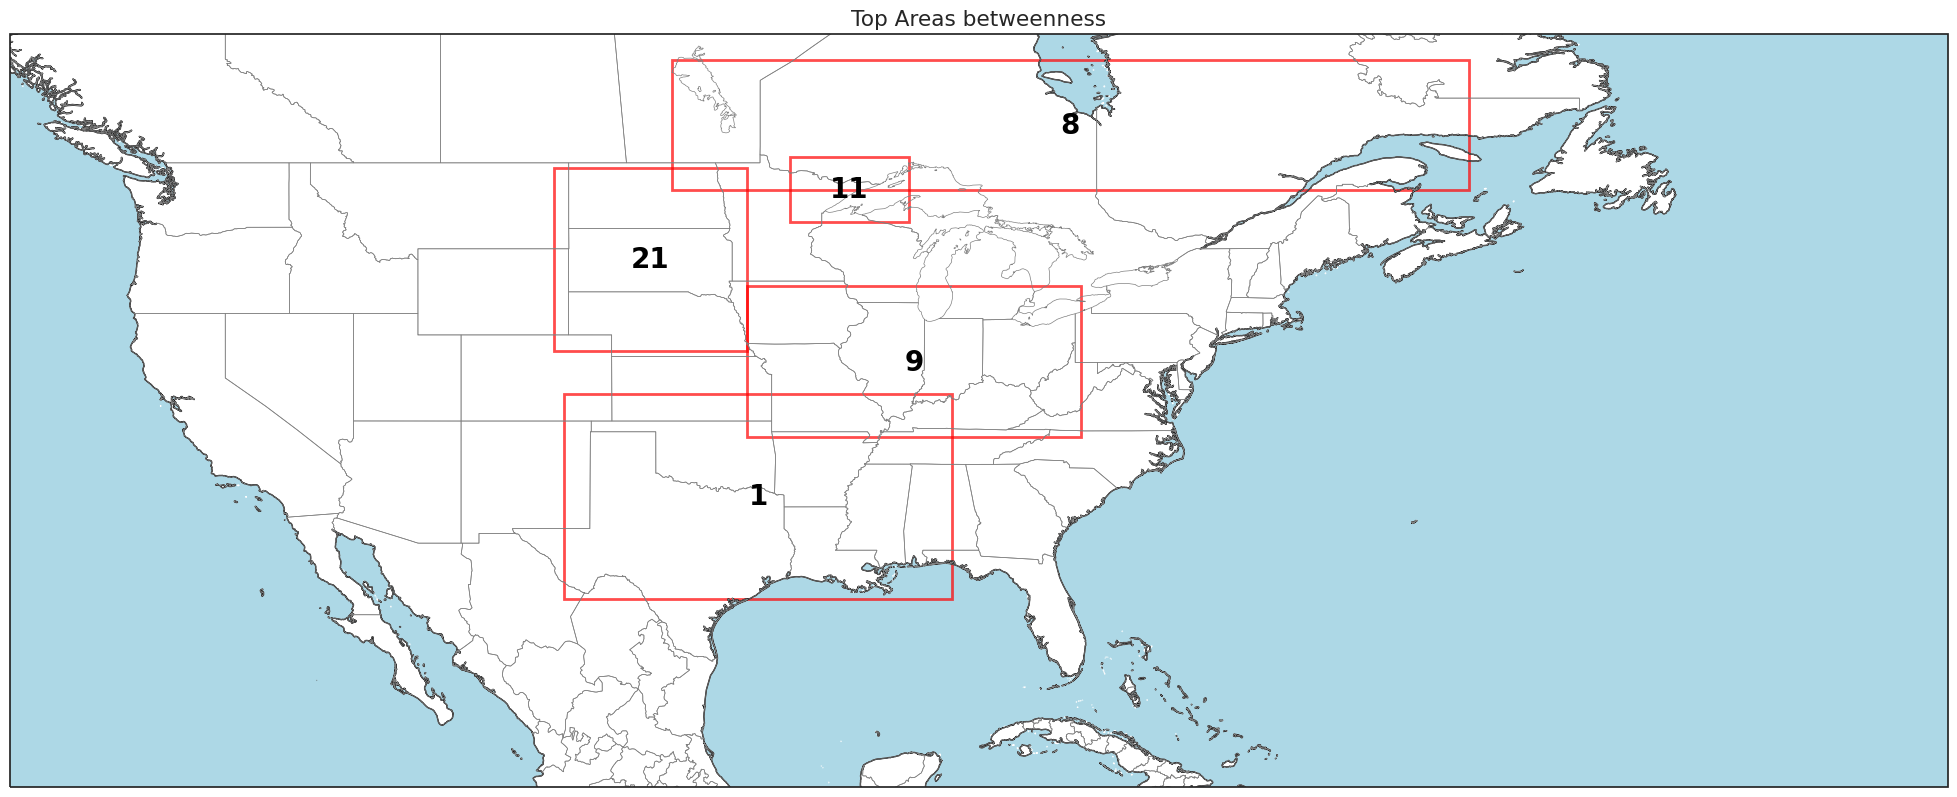

In [264]:
for name, centrality in centralities.items():
    top_nodes = sorted(centrality, key=centrality.get, reverse=True)[:5]

    node_colors = []
    node_sizes = []
    labels = {}
    for node in largest_cc_graph.nodes:
        if node in top_nodes:
            node_colors.append('red')
            node_sizes.append(1000)
            labels[node] = f"{node}"
        else:
            node_colors.append('orange')
            node_sizes.append(500)

    pos = nx.spring_layout(largest_cc_graph, seed=42)
    nx.draw(largest_cc_graph, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, cmap='coolwarm')
    nx.draw_networkx_labels(largest_cc_graph, pos, labels=labels, font_size=12, font_color='white', font_weight='bold')
    plt.title(f"Largest Connected Graph {name}")

    red_patch = plt.plot([],[], marker="o", ms=10, ls="", mec=None, color='red', label="Top Areas")[0]
    plt.legend(handles=[red_patch], loc='lower right')

    plt.show()
    fig = plt.figure(figsize=(25, 20))
    ax = plt.subplot(1, 1, 1, projection=proj)
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.coastlines(resolution='10m', linewidth=1, color='black')
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='gray')
    ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightblue')
    ax.add_feature(cfeature.LAND.with_scale('10m'), color='white', zorder=0)
    ax.set_title(f"Top Areas {name}")

    for area_idx in top_nodes:
        area = areas[area_idx]
        box = area_bounding_box(area)
        min_lat, max_lat, min_lon, max_lon = box
        rectangle = plt.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat)
        ax.add_patch(plt.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                                    fill=None, alpha=0.7, edgecolor='red', linewidth=2, transform=proj))
        rx, ry = rectangle.get_xy()
        cx = rx + rectangle.get_width()/2.0
        cy = ry + rectangle.get_height()/2.0
        ax.annotate(area_idx, (cx, cy), color='black', weight='bold', fontsize=20, ha='center', va='center')
    plt.show()

In [265]:
!pip install python-louvain

In [300]:
import community.community_louvain as community_louvain

# Calculate the communities using Louvain algorithm
partition = community_louvain.best_partition(nx.Graph(largest_cc_graph))
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)

print("Number of communities:", len(communities))

# Add latitude and longitude information to the community nodes
for community_nodes in communities.values():
    for node in community_nodes:
        lat, lon = largest_cc_graph.nodes[node]['latitude'], largest_cc_graph.nodes[node]["longitude"]
        largest_cc_graph.nodes[node]["location"] = (lat, lon)

# Create a new Folium map centered at the mean latitude and longitude of all nodes
center_coordinates = np.mean(lats), np.mean(lons)
community_map = folium.Map(location=center_coordinates, zoom_start=5, control_scale=True)

# Draw edges between nodes in each community and color them with the community color
colors = plt.cm.Set1(np.linspace(0, 1, len(communities)))
for i, community_nodes in enumerate(communities.values()):
    community_color = matplotlib.colors.to_hex(colors[i])
    for node in community_nodes:
        for neighbor in largest_cc_graph.neighbors(node):
            if neighbor in community_nodes:
                folium.PolyLine(
                    locations=[largest_cc_graph.nodes[node]["location"], largest_cc_graph.nodes[node]["location"]],
                    color=community_color,
                    weight=2,
                    opacity=0.7,
                ).add_to(community_map)

# Draw nodes with community color
for i, community_nodes in enumerate(communities.values()):
    community_color = matplotlib.colors.to_hex(colors[i])
    for node in community_nodes:
        folium.CircleMarker(
            location=largest_cc_graph.nodes[node]["location"],
            radius=10,
            color=community_color,
            fill=True,
            fill_color=community_color,
            fill_opacity=1,
            tooltip=f"Community: {i}",
        ).add_to(community_map)

community_map

Number of communities: 5


In [269]:
import folium


def area_coordinates(area):
    lats = [lat for _, lat, _ in area]
    lons = [lon for _, _, lon in area]
    return list(zip(lats, lons))


def create_interaction_map(
    area_interaction_graph, areas, center_coordinates, zoom_start=5
):
    interaction_map = folium.Map(
        location=center_coordinates, zoom_start=zoom_start, control_scale=True
    )

    for area in areas:
        area_coords = area_coordinates(area)
        folium.Polygon(
            locations=area_coords,
            color="blue",
            fill=True,
            fill_color="blue",
            fill_opacity=0.3,
        ).add_to(interaction_map)

    for i, j in area_interaction_graph.edges():
        area1_center = np.mean(area_coordinates(areas[i]), axis=0)
        area2_center = np.mean(area_coordinates(areas[j]), axis=0)
        folium.PolyLine(
            locations=[area1_center, area2_center], color="red", weight=1.5
        ).add_to(interaction_map)

    return interaction_map


lats = [lat for _, lat, _ in G.nodes()]
lons = [lon for _, _, lon in G.nodes()]
center_coordinates = (np.mean(lats), np.mean(lons))

interaction_map = create_interaction_map(
    area_interaction_graph, areas, center_coordinates
)
interaction_map

In [270]:
import folium

centroid = np.mean(np.array([node[1:] for node in areas[0]]), axis=0)
m = folium.Map(location=[centroid[0], centroid[1]], zoom_start=6)

colormap = {1: "red", 2: "blue", 3: "green", 4: "purple", 5: "orange"}

for i, area in enumerate(areas):
    centroid = np.mean(np.array([node[1:] for node in area]), axis=0)
    folium.Marker(
        location=[centroid[0], centroid[1]],
        popup=f"Area {i}",
        icon=folium.Icon(icon="cloud"),
    ).add_to(m)

for u, v, weight in area_interaction_graph.edges(data="weight"):
    color = colormap.get(weight, "black")
    u_coords = np.mean(np.array([node[1:] for node in areas[u]]), axis=0)
    v_coords = np.mean(np.array([node[1:] for node in areas[v]]), axis=0)
    folium.PolyLine(
        locations=[u_coords, v_coords], color="red", weight=6, opacity=0.7
    ).add_to(m)

m